# Example 1: Generating and Visualizing Storey Loss Functions

## Overview

This Jupyter Notebook outlines the workflow for reading inventory files that contain a list of typical nonstructural components along with their related metrics, such as quantities, demand-based fragility function parameters, and associated costs.

The required input files, in comma-separated values format, are structured as follows:
1. **Component ID**: Component Identifier (Must be positive integer)
2. **Description**: Component description
3. **EDP**: Engineering Demand Parameter. Supported options are 'PSD' and 'PFA'
4. **Typology**: Type of component. Options include 'S' for structural and 'NS' for nonstructural
5. **Performance Group**: Useful for aggregating storey loss functions when the "do_grouping" argument is set to True in the slf_generator
6. **Quantity**: Number of components
7. **Damage States**: Number of possible damage states
8. **DSx, Median**: Median seismic demand (PSD or PFA) for damage state x of component y
9. **DSx, Total Dispersion**: Total uncertainty associated with the demand
10. **DSx, Cost**: Repair cost for damage state x of component y
11. **DSx, Cost Dispersion**: Dispersion in repair costs
12. **DSx, Best Fit**: Distribution type for damage state x. Options include 'Normal' or 'Lognormal', with 'Normal' as the default

The main objectives of this notebook are:

1. **Load Component Inventory Files**: Read in component damage inventory files. The files should adhere to the structure provided in the example to ensure they are easily parsed and processed.
2. **Generate Storey Loss Functions**: Use the "slf_generator" class from oq-vmtk to create storey loss functions.
3. **Visualize Storey Loss Functions**: Use the "plotter class" from oq-vmtk to visualize the results generated by the "slf_generator" class.

This notebook provides a step-by-step guide on how to process storey loss functions efficiently, extract key performance metrics, and present the data in an understandable format. A basic understanding of earthquake engineering and data processing is recommended to make full use of the content in this notebook.


## Acknowledgements:

This example and its source code are built upon the original work by Dr. Davit Shahnazaryan and Prof. Gerard O'Reilly, whose contributions to the field have been invaluable. We would like to acknowledge and express our appreciation for Dr. Shahnazaryan’s and Prof. O'Reilly pioneering efforts in this area.

References:
1) Shahnazaryan D, O’Reilly GJ, Monteiro R. Story loss functions for seismic design and assessment: Development of tools and application. Earthquake Spectra 2021; 37(4): 2813–2839. DOI: 10.1177/87552930211023523.

2) Shahnazaryan D, O’Reilly GJ, Monteiro R. Development of a Python-Based Storey Loss Function Generator. COMPDYN 2021 - 8th International Conference on Computational Methods in Structural Dynamics and Earthquake Engineering, 2021. DOI: 10.7712/120121.8659.18567.

3) O’Reilly, G. J., & Shahnazaryan, D. (2024). On the utility of story loss functions for regional seismic vulnerability modeling and risk assessment. Earthquake Spectra, 40(3), 1933–1955. https://doi.org/10.1177/87552930241245940


## Import Libraries ## 

In [19]:
import os
import numpy as np
import pandas as pd

# Import the classes necessary for postprocessing and visualising storey loss functions
from openquake.vmtk.plotter import plotter
from openquake.vmtk.slf_generator import slf_generator

# Initialise the plotter classe
pl = plotter()

## Load Components Inventory ## 

In [20]:
# The set of drift- and acceleration-sensitive inventory of nonstructural components are compatible 
# with the FEMA P-58 database and were obtained using the "Normative Quantity Estimation Tool"
# (https://femap58.atcouncil.org/supporting-materials) assuming a residential occupancy class

inventory_directory = './in/inventory'

# Load the inventory of drift-sensitive components
inventory_psd =pd.read_csv(os.path.join(inventory_directory, 'inventory_psd.csv'))

# Print the drift-sensitive components csv contents
print(inventory_psd.head(5))

# Load the inventory of acceleration-sensitive components
inventory_pfa =pd.read_csv(os.path.join(inventory_directory, 'inventory_pfa.csv'))

# Print the acceleration-sensitive components csv contents
print(inventory_pfa.head(5))

   Component ID                        Description  EDP Typology  \
0             1         Cladding - Gross Wall Area  PSD       NS   
1             2  Cladding - Windows & Glazing Area  PSD       NS   
2             3                              Doors  PSD       NS   
3             4                            Windows  PSD       NS   
4             5                  Gypsum Partitions  PSD       NS   

   Performance Group  Quantity  Damage States  DS1, Median  DS2, Median  \
0                  1  0.071535              2       0.0338       0.0383   
1                  1  0.013935              2       0.0338       0.0383   
2                  1  0.150000              1       0.0188          NaN   
3                  1  0.220000              1       0.0188          NaN   
4                  1  0.210000              4       0.0018       0.0046   

   DS3, Median  ...  DS1, Cost Dispersion  DS2, Cost Dispersion  \
0          NaN  ...                0.1700                0.1700   
1     

## Define Storey Loss Function Generator Inputs ## 

In [21]:
# Number of damage realizations per EDP range
rlz = 500

# Engineering demand parameter range
psd_range = np.linspace(0.001, 0.5, 100) # interstorey drift in rad
pfa_range = np.linspace(0.001, 5.0, 100) # peak floor acceleration in g

# Replacement cost value
repCost = 1.0

# Currency conversion rate. This is especially useful if the compiled inventory data 
# is in a foreign currency and needs to be converted to the local market currency.
conversion_rate = 1.0

# Selected regression function. Options include "gpd", "weibull", "papadopoulos", or "lognormal". 
# For more information on the input arguments, refer to the documentation in vmtk/slf_generator.py.
regF = 'gpd'

# Performance grouping flag. Set to True if the user prefers to aggregate all sub-components' SLFs
# into a single performance group (e.g., for drift-sensitive components).
grouping_flag = True

## Generate Storey Loss Functions for Drift-Sensitive Components ## 

In [22]:
# Initialise the slf_generator class
psd_model = slf_generator(inventory_psd,
                          edp= 'PSD',
                          edp_range = psd_range,
                          do_grouping= grouping_flag,
                          conversion = conversion_rate,
                          realizations = rlz,
                          replacement_cost = repCost,
                          regression = regF)

### Generate the SLFs using the "generate()" method
out, cache = psd_model.generate()

TypeError: slf_generator.__init__() got an unexpected keyword argument 'grouping_flag'

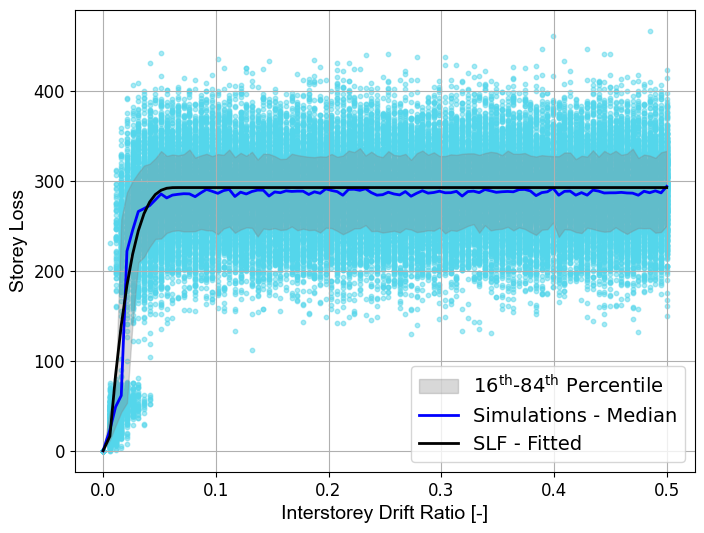

In [16]:
# Visualise the drift-sensitive nonstructural components 
# storey loss function using the "plot_slf_model" 
# method from the plotter class

pl.plot_slf_model(out, 
                  cache, 
                  'Interstorey Drift Ratio [-]', 
                  output_directory=None, 
                  plot_label='slf')

## Generate Storey Loss Functions for Acceleration-Sensitive Components ## 

In [17]:
# Initialise the slf_generator class
pfa_model = slf_generator(inventory_pfa,
                          edp= 'PFA',
                          edp_range = pfa_range,
                          do_grouping= grouping_flag,
                          conversion = conversion_rate,
                          realizations = rlz,
                          replacement_cost = repCost,
                          regression = regF)

### Generate the SLFs using the "generate()" method
out, cache = pfa_model.generate()

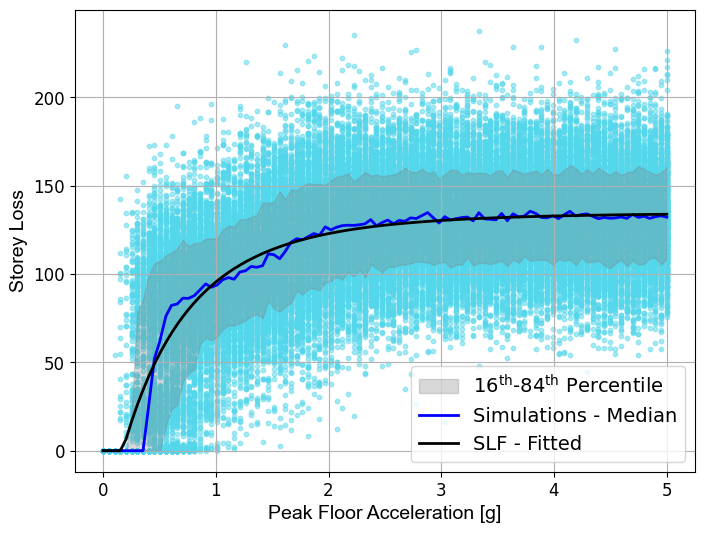

In [18]:
# Visualise the drift-sensitive nonstructural components 
# storey loss function using the "plot_slf_model" 
# method from the plotter class

pl.plot_slf_model(out, 
                  cache, 
                  'Peak Floor Acceleration [g]', 
                  output_directory=None, 
                  plot_label='slf')